In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import ultraplot as uplt

# use Times New Roman font
uplt.rc['font.family'] = 'Times New Roman'


In [2]:
product_data = []
# LessRad OLR (origin:0.05°, resampled to 1°) data path
LessRad_monthly_OLR_file = r'F:\Research\Data\other_OLR_products\LessRad_monthly_OLR_2001to2023_1degree.nc'
LessRad_ds = xr.open_dataset(LessRad_monthly_OLR_file)
LessRad_monthly_OLR = LessRad_ds['LessRad OLR']
LessRad_ds.close()
product_data.append(LessRad_monthly_OLR)
# CERES_SYN OLR (1°) data path
CERES_SYN_monthly_OLR_file = r'F:\Research\Data\other_OLR_products\CERES_SYN_monthly_OLR_2001to2023_1degree.nc'
CERES_SYN_ds = xr.open_dataset(CERES_SYN_monthly_OLR_file)
CERES_SYN_monthly_OLR = CERES_SYN_ds['CERES SYN OLR']
CERES_SYN_ds.close()
product_data.append(CERES_SYN_monthly_OLR)
# ERA5 OLR (origin:0.25°, resampled to 1°) data path
ERA5_monthly_OLR_file = r'F:\Research\Data\other_OLR_products\ERA5_monthly_OLR_2001to2023_1degree.nc'
ERA5_ds = xr.open_dataset(ERA5_monthly_OLR_file)
ERA5_monthly_OLR = ERA5_ds['ERA5 OLR']
ERA5_ds.close()
product_data.append(ERA5_monthly_OLR)

# CERES EBAF OLR(1°) data path
CERES_EBAF_monthly_OLR_file = r'F:\Research\Data\other_OLR_products\CERES_EBAF_monthly_OLR_2001to2023_1degree.nc'
CERES_EBAF_ds = xr.open_dataset(CERES_EBAF_monthly_OLR_file)
CERES_EBAF_monthly_OLR = CERES_EBAF_ds['CERES EBAF OLR']
CERES_EBAF_ds.close()
shape = CERES_EBAF_monthly_OLR.shape

# Products to compare against EBAF
product_list = ['LessRad', 'CERES SYN', 'ERA5', ]

In [3]:
# Compare the average Bias and RMSE of each product with CERES EBAF OLR
def calculate_bias_rmse(use_data, reference_data, weight):
    # use_data: np.array of the product OLR data
    # reference_data: np.arrayof the reference OLR data (CERES EBAF OLR)
    # weight: np.array of the weights (area weights)
    # Returns: bias and RMSE
    bias = ((use_data - reference_data) * weight).sum() / np.sum(weight)
    rmse = np.sqrt(((use_data - reference_data)**2 * weight).sum() / np.sum(weight))
    return bias, rmse

In [4]:
# CERES SYN OLR 1° grid longitude and latitude
ds3_lons = np.arange(-179.5, 180, 1).round(1)
ds3_lats = np.arange(89.5, -90, -1).round(1)
# Area of a grid: dA = R^2 * cos(lat) * d(lat) * d(lon) , here just R=1
ds3_weights = xr.DataArray(np.cos(np.deg2rad(ds3_lats)), dims=["latitude"], coords={"latitude": ds3_lats}) * xr.DataArray(np.full(len(ds3_lons), np.deg2rad(1)**2), dims=["longitude"], coords={"longitude": ds3_lons})

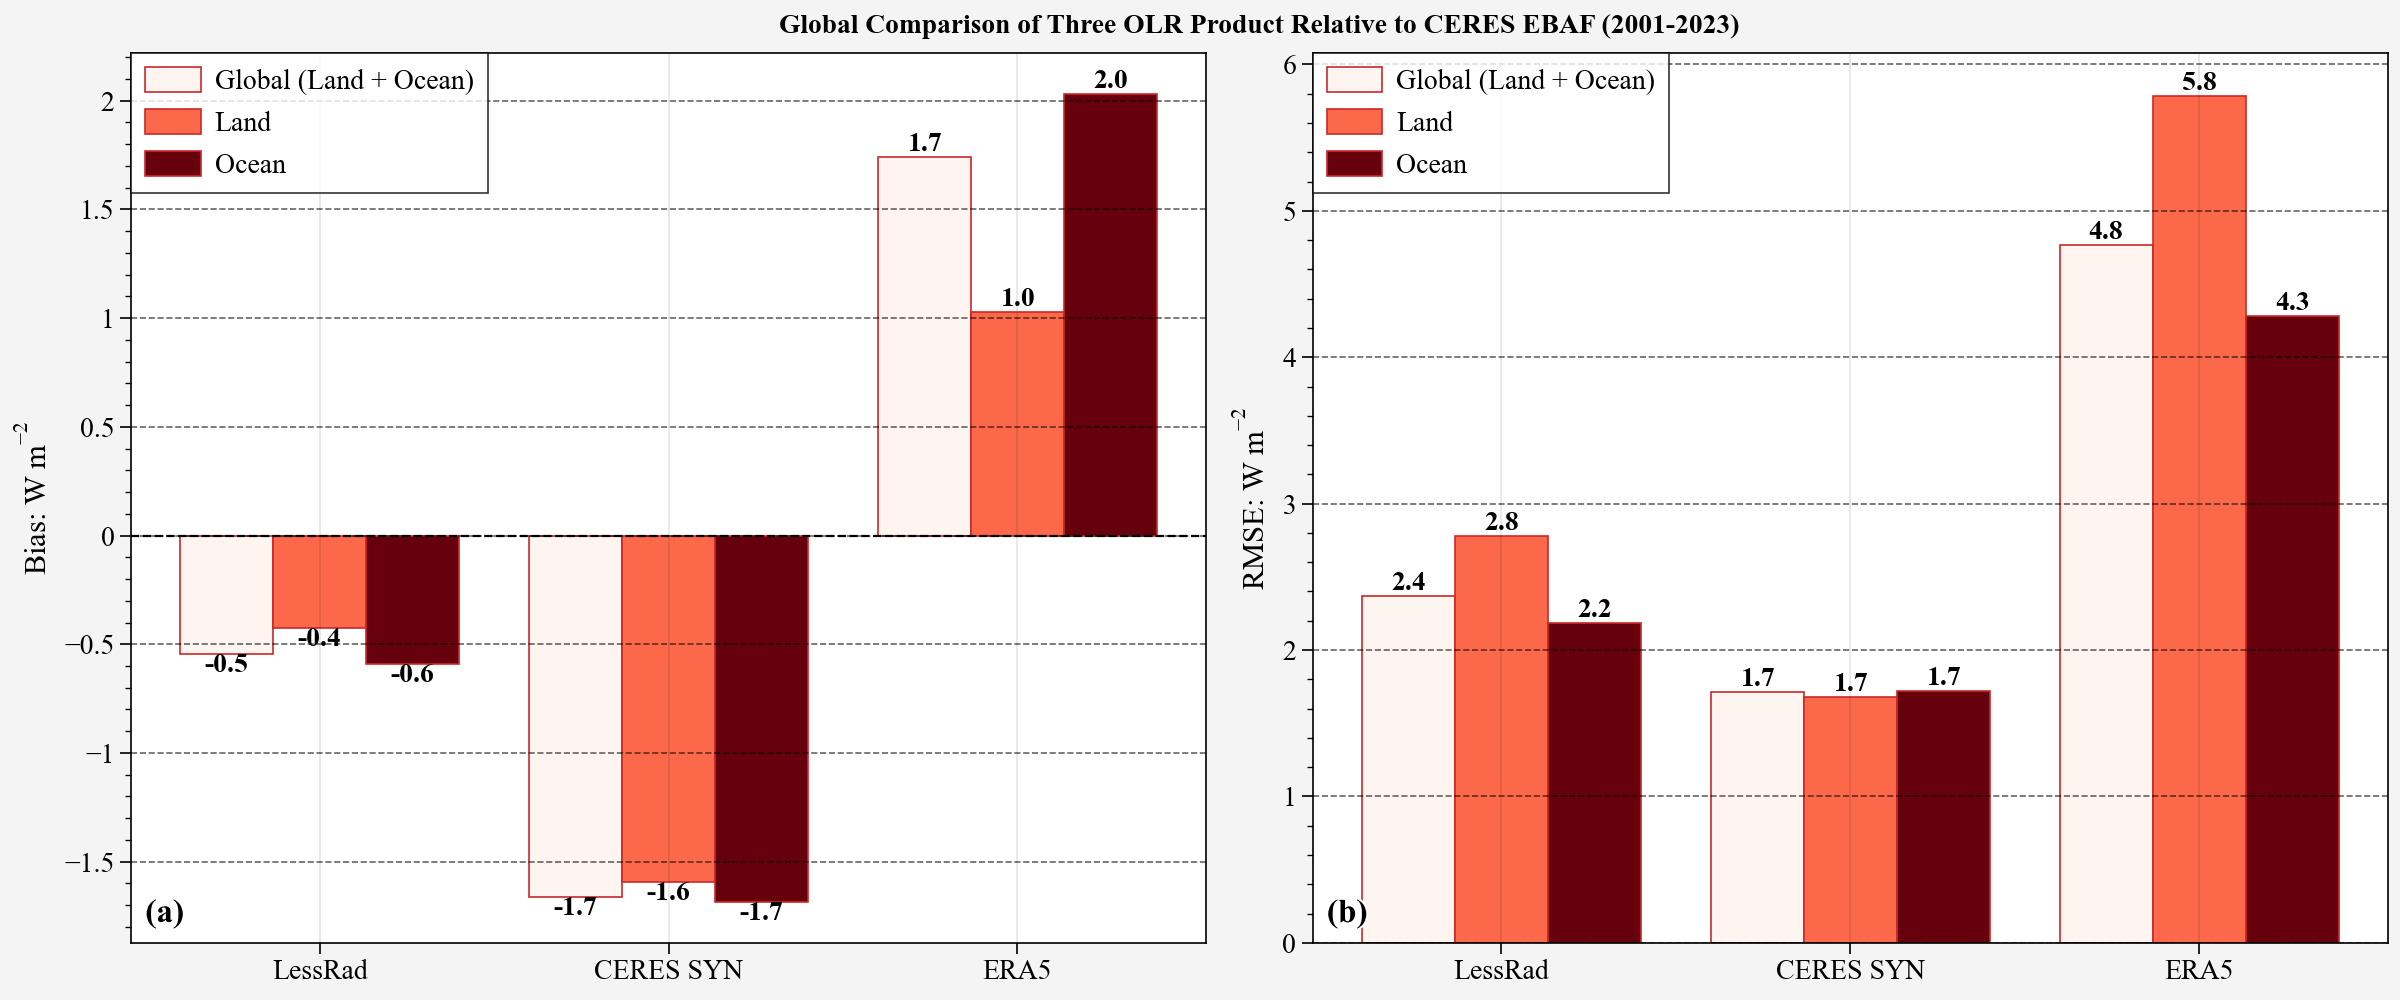

In [7]:
regions = ['Global (Land + Ocean)', 'Land', 'Ocean']
# land and sea mask (1°) data path
land_sea_mask_file = r'F:\Research\Data\other_OLR_products\land_sea_mask_1degree.nc'
land_sea_mask = xr.open_dataset(land_sea_mask_file)
land_mask = land_sea_mask['lsm'].values
land_sea_mask.close()
# create three masks for global, land, and ocean
masks = []
masks.append(np.zeros_like(land_mask))  # Global mask
masks.append(np.where(land_mask==1, 0, 1))  # Land mask
masks.append(np.where(land_mask==1, 1, 0))  # Ocean mask

# Calculate Bias and RMSE for each product in three regions
all_biases = []
all_RMSEs = []
# Loop through each region
for i in range(3):
    Biases = []
    RMSEs = []
    # choose region mask
    use_mask = masks[i]# Flatten the mask for 1D indexing
    # True means the mask is 1, False means the mask is 0
    # broadcast the mask to match the shape of the product data
    use_mask_3d = np.broadcast_to(use_mask[np.newaxis,...], shape)
    use_weight_3d = np.broadcast_to(ds3_weights.values[np.newaxis,...], shape)
    # Loop through each product
    for product in product_data:  # Exclude CERES EBAF from the loop
        # Apply land/sea mask
        x = product.values  # Apply mask to the product data
        y = CERES_EBAF_monthly_OLR.values
        use_x = np.ma.array(x, mask=use_mask_3d).compressed()  # Flatten the masked data
        use_y = np.ma.array(y, mask=use_mask_3d).compressed()
        use_weight = np.ma.array(use_weight_3d, mask=use_mask_3d).compressed()
        bias, rmse = calculate_bias_rmse(use_x, use_y, use_weight)
        Biases.append(bias)
        RMSEs.append(rmse)
    all_biases.append(Biases)
    all_RMSEs.append(RMSEs)
# Bias and RMSE list convert to DataFrame
bias_df = pd.DataFrame(all_biases, index=regions, columns=product_list)
rmse_df = pd.DataFrame(all_RMSEs, index=regions, columns=product_list)

# --- Figure 5 Code: Overview of Global Performance vs. CERES EBAF OLR (Bar Chart) ---
fig, axes = uplt.subplots(nrows=1, ncols=2, figsize=(12, 5), sharey=False) # Separate Y-axis for Bias/RMSE
# Plot Bias
# Draw bar chart of five OLR products
ax1 = axes[0, 0]
ax1.bar(bias_df.T, cycle="Reds", edgecolor="red9",)
# Add label
for c in ax1.containers:
    ax1.bar_label(c, label_type='edge', fmt='%.1f', size=10, fontweight="bold")
ax1.legend(loc='ul', ncol=1, frameon=True, fontsize=10)
ax1.axhline(0, color='black', linewidth=0.8, linestyle='--')
ax1.set_ylabel('Bias: W $\\rm{m^{-2}}$', fontsize=11)
ax1.tick_params(axis='x', rotation=0, labelsize=10)
ax1.tick_params(axis='y', labelsize=10)
ax1.grid(axis='y', linestyle='--', alpha=0.6)

# Plot RMSE
ax2 = axes[0,1]
ax2.bar(rmse_df.T, cycle="Reds", edgecolor="red9")
# Add label
for c in ax2.containers:
    ax2.bar_label(c, label_type='edge', fmt='%.1f', size=10, fontweight="bold")
ax2.legend(loc='ul', ncol=1, frameon=True, fontsize=10)
ax2.set_ylabel('RMSE: W $\\rm{m^{-2}}$', fontsize=11)
ax2.tick_params(axis='x', rotation=0, labelsize=10)
ax2.tick_params(axis='y', labelsize=10)
ax2.grid(axis='y', linestyle='--', alpha=0.6)
ax2.set_ylim(bottom=0) # RMSE should be non-negative

fig.format(
    suptitle="Global Comparison of Three OLR Product Relative to CERES EBAF (2001-2023)",
    abc="(a)", abcloc="ll", abcsize=12,)
# Save the figure
fig.savefig('Fig5_Global_Comparison_of_Three_OLR_Product_Relative_to_CERES_EBAF_(2001-2023).tif', dpi=300, bbox_inches='tight')
